In [6]:
# pip install PyWavelets


In [7]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.signal import butter, filtfilt, resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split



In [8]:

with open("train_right.txt", "r") as file:
    lines = file.readlines()


new_lines = [line.strip() + "\tright\n" for line in lines]

# update file
with open("train_right.txt", "w") as file:
    file.writelines(new_lines)



with open("train_left.txt", "r") as file:
    lines = file.readlines()


new_lines = [line.strip() + "\tleft\n" for line in lines]

# update file
with open("train_left.txt", "w") as file:
    file.writelines(new_lines)


file_paths = ['train_right.txt', 'train_left.txt'] 
output_file = 'Train_Signals.txt' 


with open(output_file, 'w') as outfile:
    for file_path in file_paths:
        
        with open(file_path, 'r') as infile:
            outfile.write(infile.read())

print(f"file created: {output_file}")




file created: Train_Signals.txt


In [9]:

with open("test_right.txt", "r") as file:
    lines = file.readlines()


new_lines = [line.strip() + "\tright\n" for line in lines]

# update file
with open("test_right.txt", "w") as file:
    file.writelines(new_lines)




with open("test_left.txt", "r") as file:
    lines = file.readlines()


new_lines = [line.strip() + "\tleft\n" for line in lines]

# update file
with open("test_left.txt", "w") as file:
    file.writelines(new_lines)



file_paths = ['test_right.txt', 'test_left.txt']  
output_file = 'Test_Signals.txt' 


with open(output_file, 'w') as outfile:
    for file_path in file_paths:
    
        with open(file_path, 'r') as infile:
            outfile.write(infile.read()) 
print(f"file created: {output_file}")




file created: Test_Signals.txt


Reading Files

In [10]:
def read_file_to_list(file_path):
    with open(file_path, 'r') as file:
        features = []
        labels = []
        for line in file:
            parts = line.split() 
            row = list(map(int, parts[:-1])) #excpet the label column 
            label = parts[-1]  # get label column :str
            features.append(row)
            labels.append(label)

    return features, labels


file_train= 'Train_Signals.txt'
file_test = 'Test_Signals.txt'


features_Train ,label_Train = read_file_to_list(file_train)
features_Test , label_Test= read_file_to_list(file_test)

print(len(features_Test))
print(len(features_Train))
print(len(label_Test))
print(len(label_Train))

# print(features_Test)
# print(features_Train)
# print(label_Test)
# print(label_Train)

10
30
10
30


Preprocessing

30
30
30
30
30


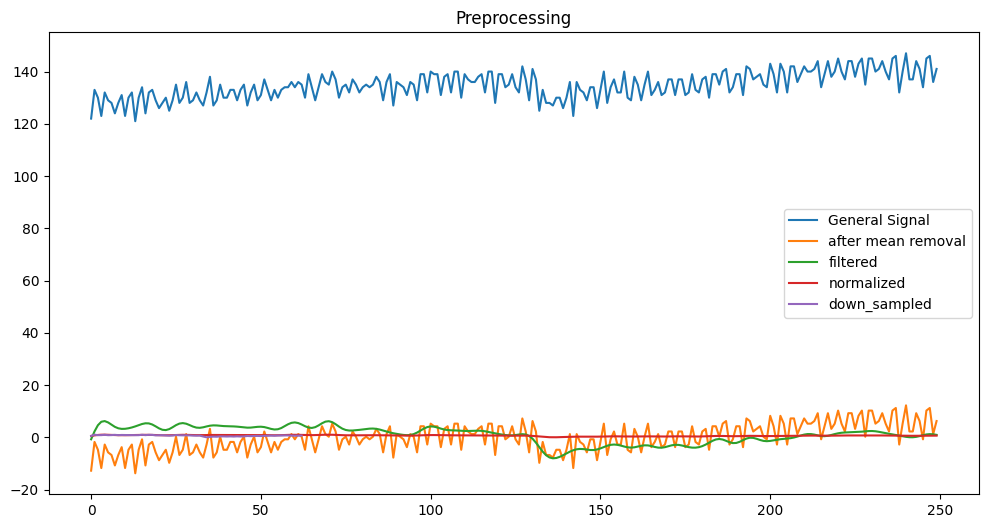

10
10
10
10
10


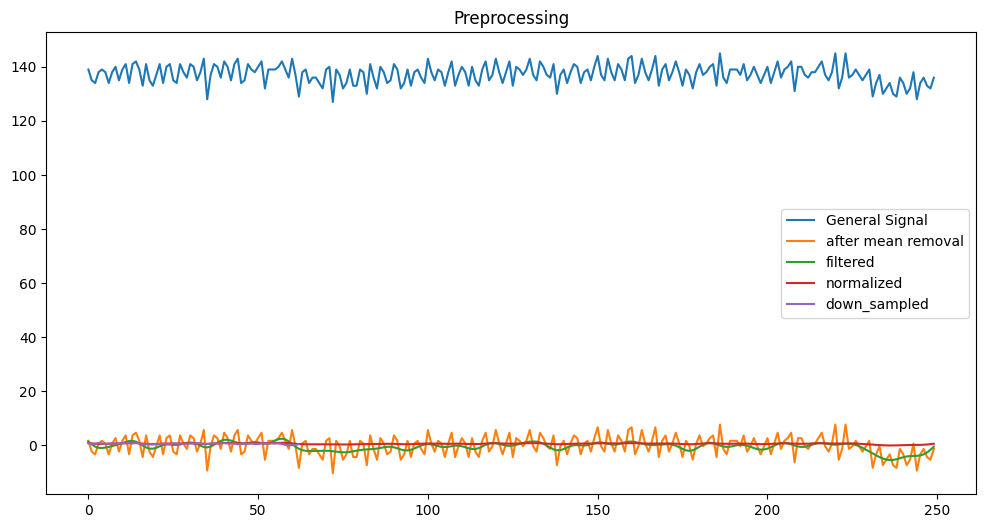

In [11]:
def remove_mean(signal):
    mean_removed_signal = signal - np.mean(signal)
    return mean_removed_signal

def bandpass_filter(sampling_rate, signal, low_cutoff=0.5, high_cutoff=20.0):
    nyquist = sampling_rate * 0.5
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal


def normalize(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    normalized_signal = (signal - min_val) / (max_val - min_val)
    return normalized_signal

# max =156 freq 176
def downsample(signal, factor):
    downsampled_signal = signal[::factor]
    return downsampled_signal

def wavelet_feature_extraction(signal, wavelet='db2', level=2):
    if len(signal) == 0:
        raise ValueError("Input signal is empty.")
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    approximation = coeffs[0]
    details = coeffs[1:]
    # print("len of coff  " ,len(coeffs))
    # print("coff of [0] " ,coeffs[0])
    # print(approximation[0])
    # print("len coff of [0] " ,len(coeffs[0]))
    # print("len coff of [1] " ,len(coeffs[1]))
    # print("len coff of [2] " ,len(coeffs[2]))
    # print("app of [0] " ,approximation[0])
    # print("len of app [0] " ,len(approximation[0]))
    return approximation



def process(signal,sampling_rate=176):
    mean_removed_data = [remove_mean(np.array(row)) for row in signal]
    print(len(mean_removed_data))
    filtered_data = [bandpass_filter(176, row) for row in mean_removed_data]
    print(len(filtered_data))
    normalized_data = [normalize(row) for row in filtered_data]
    print(len(normalized_data))
    downsampled_data = [downsample(row, 4) for row in normalized_data]
    print(len(downsampled_data))
    wavelet_features = wavelet_feature_extraction(downsampled_data)
    print(len(wavelet_features))
    # print(wavelet_features[5])
    plt.figure(figsize=(12, 6))
    plt.title("Preprocessing")
    plt.plot(signal[0],label="General Signal")
    plt.plot(mean_removed_data[0],label="after mean removal")
    plt.plot(filtered_data[0],label="filtered")
    plt.plot(normalized_data[0],label="normalized")
    plt.plot(downsampled_data[0],label="down_sampled")
    plt.legend()
    plt.show()
    return wavelet_features


wavelet_train=process(features_Train)
wavelet_test= process(features_Test)
# print(wavelet_train)





In [12]:
# print("wavelet_train shape:", np.shape(wavelet_train))
# print("wavelet_test shape:", np.shape(wavelet_test))
# print("label_Train shape:", np.shape(label_Train))
# print("label_Test shape:", np.shape(label_Test))
# print(len(wavelet_train))
# print(len(wavelet_test))
# print(len(label_Train))
# print(len(label_Test))

In [13]:
X_train, X_test, y_train, y_test = wavelet_train,wavelet_test,label_Train,label_Test

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pywt
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def knn_classification(X_train, X_test, y_train, y_test, n_neighbors=3):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)


    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(report)

    return knn, y_pred


X_train = np.array(wavelet_train).reshape(len(wavelet_train), -1)
X_test = np.array(wavelet_test).reshape(len(wavelet_test), -1)

y_train = np.ravel(label_Train)
y_test = np.ravel(label_Test)

knn_model, predictions = knn_classification(X_train, X_test, y_train, y_test, n_neighbors=5)


Accuracy: 80.00%
Confusion Matrix:
[[5 0]
 [2 3]]
Classification Report:
              precision    recall  f1-score   support

        left       0.71      1.00      0.83         5
       right       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10



In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
acc1=[]
acc2=[]
for i in range (2,22):
  dtc1=RandomForestClassifier(max_depth=i,criterion="entropy",random_state=42)
  dtc1.fit(X_train,y_train)
  dtc2=RandomForestClassifier(max_depth=i,criterion="gini",random_state=42)
  dtc2.fit(X_train,y_train)
  acc1.append(dtc1.score(X_test, y_test))
  acc2.append(dtc2.score(X_test, y_test))

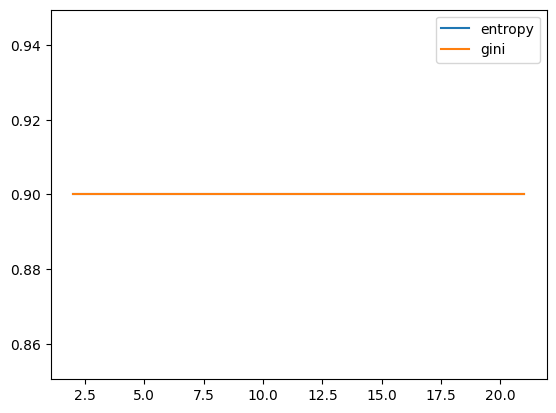

In [16]:
plt.plot(range(2,22),acc1,label="entropy")
plt.plot(range(2,22),acc2,label="gini")
plt.legend()

In [17]:
random_forest_model = RandomForestClassifier(criterion="gini", max_depth=19,random_state=40)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
accuracy_RF = accuracy_score(y_test, y_pred)
print(f"Accuracy of the RandomForestClassifier model: {accuracy_RF:.2f}")

Accuracy of the RandomForestClassifier model: 0.90


,Model,Accuracy_score
1,Random Forest,0.9
0,Classification Knn,0.8


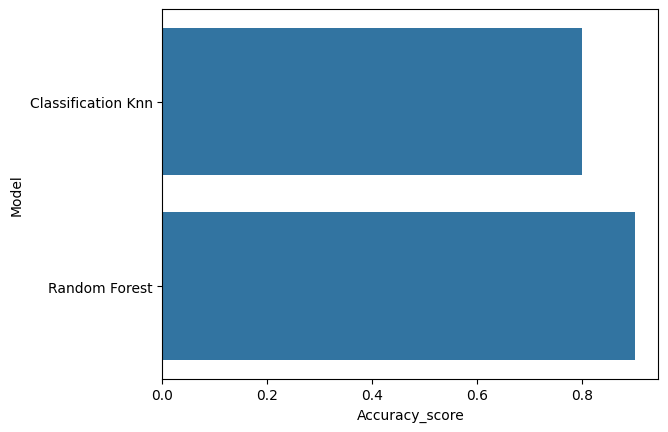

In [18]:
import seaborn as sns
from sklearn.metrics import accuracy_score

accuracy_KNN = accuracy_score(y_test, predictions)

models = pd.DataFrame({
    'Model': ['Classification Knn', 'Random Forest'],
    'Accuracy_score': [accuracy_KNN, accuracy_RF]
})
sns.barplot(x='Accuracy_score', y='Model', data=models)
models.sort_values(by='Accuracy_score', ascending=False)

In [19]:
print(y_pred)

['right' 'left' 'right' 'right' 'right' 'left' 'left' 'left' 'left' 'left']


In [20]:
import joblib
file='drop'
joblib.dump(random_forest_model,"drop")
model=joblib.load(open("drop",'rb'))

In [21]:
file='drop1'
joblib.dump(knn_model,"drop1")
model=joblib.load(open("drop1",'rb'))

In [22]:
joblib.dump(accuracy_RF, "accur1")

['accur1']

In [23]:
file='drop2'
joblib.dump(process,"drop2")
fun=joblib.load(open("drop2",'rb'))